# Assignment 2: Generative Adversarial Network (GAN)

## Meta Instructions
1. Environment: If you use Google Colab, the default environment is OK. For your own environment, install pytorch >= 1.7.0 and torchvision >= 0.8.0 to avoid any issues caused by package versions.

2. Finish coding tasks according to instructions in this file. **Only** change the code in the required area, which is indicated by "Your code starts here" and "Your code ends here". Do not modify anywhere else including comments. 1 GPU is sufficient for this task.

2. Submission: submit a zip file named "StuID.zip" (e.g., "A0123456J.zip") to Canvas. Note that it is **NOT** NUSNET ID. The zip file should **only** include "main.ipynb" with your implemented code (yes, it's just this file). **Keep the intermediate results in this notebook. We won't run it for you.** The submissison deadline is **23:59 Feb 3**.


Please **strictly** follow the above instructions, otherwise a grade deduction will be conducted.

For any question, please do one of the following actions with priority:
1. Search for similar questions on Slack
2. Propose a new question on Slack
3. For non-public questions, e-mail to Xiangyu Peng (e0792500@u.nus.edu) with the subject starting with "CS5260 2023 Spring"

## Get Started

In this assignment, we will learn how to build a GAN and train it. Training a GAN is like a minmax game: The generator of GAN will be trained to create fake iamges that can fool the discriminator, while the discriminator is trained to distinguish real images from those generated fake ones. The algorithm of training GANs is shown below.

<img src="./resources/gan.png" alt="Alternative text" width="800"/>

We are going to implement this algorithm in this assignment. We will use the MNIST dataset for training.

## Load the MNIST dataset

The MNIST dataset is a database of handwritten digits. It contains 60,000 training images and 10,000 testing images. All the images are black and white, i.e., have only one channel. We will only use the training samples since our task is generation rather than classification. Let's first download it and see how it looks.

In [1]:
import os
import time
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class Args:
    epochs = 50
    batch_size = 64
    lr = 2e-4
    latent_dim = 128
    img_size = 28
    channels = 1
    save_interval = 10
    log_interval = 100
    
args = Args()
img_shape = (args.channels, args.img_size, args.img_size)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/home/nus-pxy/anaconda3/envs/mm3d/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


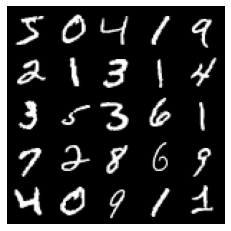

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets

# download and build dataset
os.makedirs("./data/mnist", exist_ok=True)
PIL2tensor = transforms.ToTensor()
tensor2PIL = transforms.ToPILImage()
train_set = datasets.MNIST('./data/mnist', train=True, download=True, transform=PIL2tensor)

# show image grid
def display_image(image, title=None):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

imgs = [train_set[i][0] for i in range(25)]
img_grid = tensor2PIL(make_grid(imgs, nrow=5))
display_image(img_grid)

We also need to build a dataloader for training. It will be used later.

In [3]:
transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, num_workers=10, shuffle=True, drop_last=True)
num_iters = len(dataloader)

## Build a GAN

The next thing is to build a GAN model, which consists of a generator and a discriminator. We have already defined them for you.

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()

        self.init_size = img_size[-1] // 4
        self.fc = nn.Linear(latent_dim, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_size[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()

        def discriminator_block(in_filters, out_filters, norm=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if norm:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_size[0], 16),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size[-1] // 2 ** 4 + 1  # 2
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.flatten(1)
        pred = self.adv_layer(out)
        return pred

In [6]:
model_g = Generator(args.latent_dim, img_shape).to(device)
model_d = Discriminator(img_shape).to(device)

## Train a GAN

Here comes the key part: to train a GAN. The training process of a GAN is different from that of a plain classifier. It can be regarded as a minmax game between the generator and the discriminataor. Thus, the training actually has two stages: 1) train the discriminator; 2) train the generator. Please familiarize yourself with the algorithm shown above and follow the hints to implement the code.

In [7]:
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if f == '':
        f = '0ms'
    return f

criterion = nn.BCELoss().to(device)
optimizer_G = torch.optim.Adam(model_g.parameters(), lr=args.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(model_d.parameters(), lr=args.lr, betas=(0.5, 0.999))
model_g.train()
model_d.train()
epochs = args.epochs

Epoch [1/50][100/937] - loss_g: 0.6899, loss_d: 0.6737
Epoch [1/50][200/937] - loss_g: 0.7022, loss_d: 0.6831
Epoch [1/50][300/937] - loss_g: 0.6953, loss_d: 0.7040
Epoch [1/50][400/937] - loss_g: 0.7091, loss_d: 0.6795
Epoch [1/50][500/937] - loss_g: 0.6627, loss_d: 0.6684
Epoch [1/50][600/937] - loss_g: 0.7196, loss_d: 0.6753
Epoch [1/50][700/937] - loss_g: 0.7009, loss_d: 0.6726
Epoch [1/50][800/937] - loss_g: 0.8399, loss_d: 0.6384
Epoch [1/50][900/937] - loss_g: 0.7870, loss_d: 0.6471
Epoch [1] training time: 28s
Epoch [2/50][100/937] - loss_g: 0.8558, loss_d: 0.6873
Epoch [2/50][200/937] - loss_g: 0.6594, loss_d: 0.5939
Epoch [2/50][300/937] - loss_g: 0.8022, loss_d: 0.6478
Epoch [2/50][400/937] - loss_g: 0.7954, loss_d: 0.6263
Epoch [2/50][500/937] - loss_g: 0.8377, loss_d: 0.6581
Epoch [2/50][600/937] - loss_g: 0.6928, loss_d: 0.6777
Epoch [2/50][700/937] - loss_g: 0.8453, loss_d: 0.6247
Epoch [2/50][800/937] - loss_g: 0.6994, loss_d: 0.5735
Epoch [2/50][900/937] - loss_g: 0.73

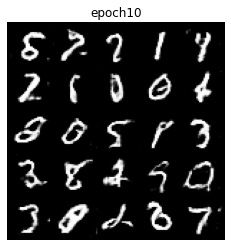

Epoch [10] training time: 22s
Epoch [11/50][100/937] - loss_g: 1.3856, loss_d: 0.3020
Epoch [11/50][200/937] - loss_g: 1.7505, loss_d: 0.5605
Epoch [11/50][300/937] - loss_g: 1.1549, loss_d: 0.3189
Epoch [11/50][400/937] - loss_g: 0.8974, loss_d: 0.3700
Epoch [11/50][500/937] - loss_g: 1.2306, loss_d: 0.4301
Epoch [11/50][600/937] - loss_g: 1.1149, loss_d: 0.5502
Epoch [11/50][700/937] - loss_g: 1.0039, loss_d: 0.4513
Epoch [11/50][800/937] - loss_g: 1.3754, loss_d: 0.3749
Epoch [11/50][900/937] - loss_g: 1.1694, loss_d: 0.6194
Epoch [11] training time: 19s
Epoch [12/50][100/937] - loss_g: 0.7462, loss_d: 0.3665
Epoch [12/50][200/937] - loss_g: 1.3075, loss_d: 0.7644
Epoch [12/50][300/937] - loss_g: 1.1192, loss_d: 0.3354
Epoch [12/50][400/937] - loss_g: 1.6174, loss_d: 0.4098
Epoch [12/50][500/937] - loss_g: 0.8870, loss_d: 0.6739
Epoch [12/50][600/937] - loss_g: 1.3948, loss_d: 0.2322
Epoch [12/50][700/937] - loss_g: 1.2851, loss_d: 0.3889
Epoch [12/50][800/937] - loss_g: 1.2417, los

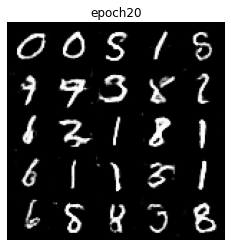

Epoch [20] training time: 20s
Epoch [21/50][100/937] - loss_g: 0.9145, loss_d: 0.4110
Epoch [21/50][200/937] - loss_g: 1.5204, loss_d: 0.3495
Epoch [21/50][300/937] - loss_g: 1.9018, loss_d: 0.3097
Epoch [21/50][400/937] - loss_g: 1.3913, loss_d: 1.0771
Epoch [21/50][500/937] - loss_g: 1.3542, loss_d: 0.6606
Epoch [21/50][600/937] - loss_g: 0.4572, loss_d: 0.6000
Epoch [21/50][700/937] - loss_g: 1.2976, loss_d: 0.4561
Epoch [21/50][800/937] - loss_g: 1.1357, loss_d: 0.3721
Epoch [21/50][900/937] - loss_g: 1.5826, loss_d: 0.3162
Epoch [21] training time: 19s
Epoch [22/50][100/937] - loss_g: 0.5166, loss_d: 0.9051
Epoch [22/50][200/937] - loss_g: 1.2264, loss_d: 0.3886
Epoch [22/50][300/937] - loss_g: 1.1953, loss_d: 0.5841
Epoch [22/50][400/937] - loss_g: 0.5571, loss_d: 0.6733
Epoch [22/50][500/937] - loss_g: 1.5286, loss_d: 0.7586
Epoch [22/50][600/937] - loss_g: 1.2889, loss_d: 0.4978
Epoch [22/50][700/937] - loss_g: 1.3029, loss_d: 0.5048
Epoch [22/50][800/937] - loss_g: 0.9254, los

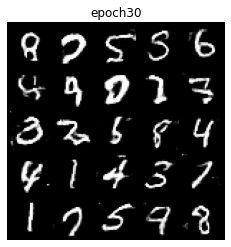

Epoch [30] training time: 17s
Epoch [31/50][100/937] - loss_g: 1.3460, loss_d: 0.9802
Epoch [31/50][200/937] - loss_g: 1.6765, loss_d: 0.6925
Epoch [31/50][300/937] - loss_g: 1.6423, loss_d: 0.7358
Epoch [31/50][400/937] - loss_g: 0.9738, loss_d: 0.4775
Epoch [31/50][500/937] - loss_g: 1.4957, loss_d: 0.5047
Epoch [31/50][600/937] - loss_g: 1.1108, loss_d: 0.6622
Epoch [31/50][700/937] - loss_g: 0.3685, loss_d: 0.2859
Epoch [31/50][800/937] - loss_g: 1.1008, loss_d: 0.1413
Epoch [31/50][900/937] - loss_g: 0.9540, loss_d: 0.3243
Epoch [31] training time: 21s
Epoch [32/50][100/937] - loss_g: 2.2474, loss_d: 0.4672
Epoch [32/50][200/937] - loss_g: 1.3688, loss_d: 0.3132
Epoch [32/50][300/937] - loss_g: 0.5467, loss_d: 0.4832
Epoch [32/50][400/937] - loss_g: 1.1118, loss_d: 0.4086
Epoch [32/50][500/937] - loss_g: 0.9456, loss_d: 0.6461
Epoch [32/50][600/937] - loss_g: 1.4398, loss_d: 0.7163
Epoch [32/50][700/937] - loss_g: 1.8654, loss_d: 0.8758
Epoch [32/50][800/937] - loss_g: 1.3723, los

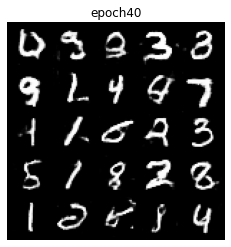

Epoch [40] training time: 16s
Epoch [41/50][100/937] - loss_g: 2.3358, loss_d: 0.5005
Epoch [41/50][200/937] - loss_g: 0.9335, loss_d: 0.4663
Epoch [41/50][300/937] - loss_g: 0.8475, loss_d: 0.2512
Epoch [41/50][400/937] - loss_g: 1.2519, loss_d: 0.8193
Epoch [41/50][500/937] - loss_g: 1.7984, loss_d: 0.6638
Epoch [41/50][600/937] - loss_g: 2.4994, loss_d: 0.4947
Epoch [41/50][700/937] - loss_g: 1.4230, loss_d: 0.4970
Epoch [41/50][800/937] - loss_g: 0.8566, loss_d: 0.2920
Epoch [41/50][900/937] - loss_g: 1.9249, loss_d: 0.4570
Epoch [41] training time: 21s
Epoch [42/50][100/937] - loss_g: 1.0680, loss_d: 0.2660
Epoch [42/50][200/937] - loss_g: 1.2172, loss_d: 0.9152
Epoch [42/50][300/937] - loss_g: 2.0291, loss_d: 0.1445
Epoch [42/50][400/937] - loss_g: 2.5639, loss_d: 0.2194
Epoch [42/50][500/937] - loss_g: 0.9419, loss_d: 0.7514
Epoch [42/50][600/937] - loss_g: 1.5053, loss_d: 0.4738
Epoch [42/50][700/937] - loss_g: 0.5719, loss_d: 0.3343
Epoch [42/50][800/937] - loss_g: 3.1479, los

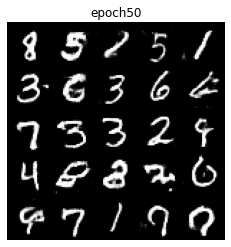

Epoch [50] training time: 19s
Total training time: 17m37s


In [8]:
t0 = time.time()
for epoch in range(1, args.epochs + 1):
    t0_i = time.time()
    for idx, (imgs, _) in enumerate(dataloader, start=1):
        imgs = imgs.to(device)
        gt_real = torch.ones(imgs.shape[0], 1).to(device)
        gt_fake = torch.zeros(imgs.shape[0], 1).to(device)

        # ---------------------------
        #  1. Train the discriminator
        # ---------------------------
        
        """
        TODO (1): Sample a batch of noise samples from Gaussian distribution.
        Hints:
            1. Use torch.randn() for sampling.
            2. Assign these samples to variable z, which is in accordance with Algorithm 1. z should be a tensor with shape [B, C], where
                B is the batch size and C is the latent dimension.
        """
        z = None
        ################################
        # Your code starts here
        ################################
        
        z = torch.randn(imgs.shape[0], args.latent_dim).to(device)

        ################################
        # Your code ends here
        ################################
        assert z.shape == torch.Size([args.batch_size, args.latent_dim])

        
        """
        TODO (2): Compute loss for the discriminator, denoted as loss_d
        Hints:
            1. You only need to implment the forward pass of discriminator. The fake images and backward pass are already prepared.
            2. In training of the discriminator, we don't want the gradient flow back to the generator. 
                Use imgs_fake.detach() to achieve this.
            3. loss_d has two parts: loss for the real images L_real and loss for the fake images L_fake. Use the given criterion
                and gt_real/gt_fake to compute L_real/L_fake.
            4. Requirement: compute loss_d as loss_d = (L_real + L_fake) / 2
        """
        loss_d = None
        imgs_fake = model_g(z)
        ################################
        # Your code starts here
        ################################
        
        imgs_real = imgs
        pred_real_d = model_d(imgs_real)
        loss_real_d = criterion(pred_real_d, gt_real)
        

        pred_fake_d = model_d(imgs_fake.detach())
        loss_fake_d = criterion(pred_fake_d, gt_fake)
        loss_d = (loss_real_d + loss_fake_d) / 2

        ################################
        # Your code ends here
        ################################
        
        optimizer_D.zero_grad()
        loss_d.backward()
        optimizer_D.step()


        # ---------------------------
        #  2. Train the generator
        # ---------------------------
        """
        TODO (3): Compute the loss for the generator, denoted as loss_g
        Hints:
            1. You only need to implment the forward pass. The backward pass is already given.
            2. Use the given criterion to compute loss_g
        """
        loss_g = None
        ################################
        # Your code starts here
        ################################
        
        pred_fake_g = model_d(imgs_fake)
        loss_g = criterion(pred_fake_g, gt_real)

        ################################
        # Your code ends here
        ################################

        optimizer_G.zero_grad()
        loss_g.backward()
        optimizer_G.step()

        if idx % args.log_interval == 0:
            print(f'Epoch [{epoch}/{args.epochs}][{idx}/{num_iters}] - '
                  f'loss_g: {loss_g.item():.4f}, loss_d: {loss_d.item():.4f}')

    if epoch % args.save_interval == 0:
        img_grid = tensor2PIL(make_grid(imgs_fake[:25].cpu(), nrow=5, normalize=True))
        display_image(img_grid, title=f'epoch{epoch}')
    
    t1_i = time.time()
    t_i = format_time(t1_i - t0_i)
    print(f'Epoch [{epoch}] training time: {t_i}')

t1 = time.time()
tot = format_time(t1 - t0)
print(f'Total training time: {tot}')

The total training time on a single GPU should be no longer than 30 minutes. An example output of a moderately trained generator is shown below. The quality of your output should be better or close to it. Since different runs usually give different results due to random initialization, it's ok you train the model multiple times and keep the best result. **To get the score for the generated image**, the minimum requirement is at least one patch (out of 25) in the grid (from the 50th epoch) can be recognized as a digit.

<img src="./resources/epoch50.png" align="left" width="300"/>